# Discharge Notes and Readmission Rates: NLP

This notebook is for the processing the cleaned dataset through different vectorizers and models. Please see the following for the other notebooks:
* [EDA Notebook](01_EDA.ipynb)
* [Modeling with Additional Featuers](03_Modeling_Additional_Features)

## Import

Import the relevant libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

#modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xg
from sklearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.utils import class_weight

## Functions

This section is for any functions created for the analysis.

In [2]:
def scores(model, X, y, set_type, return_conf=False):
    '''
    This function takes in an already fitted model, X, y, and
    the type of data (train, validation, or test) in str format,
    and prints out the accuracy and recall scores. The function
    also prints out the confusion matrix
    '''
    pred = model.predict(X)
    acc_score = accuracy_score(y, pred)
    rec_score = recall_score(y, pred)
    
    print("{} Scores".format(set_type))
    print("accuracy: ", acc_score)
    print("recall:   ", rec_score)
    fig, ax = plt.subplots(figsize=(6,6))
    #set background color to white
    fig.patch.set_facecolor('white')
    ax.set_title(set_type)
    plot_confusion_matrix(model, X, y, ax=ax)
    if return_conf == True:
        return fig, round(acc_score*100,1), round(rec_score*100,1)
    if return_conf == False:
        return round(acc_score*100,1), round(rec_score*100,1) 

## Reading in the Data

Here, I read in the cleand dataset from the previous EDA folder.

In [3]:
df = pd.read_csv('data/admissions_cleaned.csv.gz', compression='gzip')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52726 entries, 0 to 52725
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ADMISSION_TYPE      52726 non-null  object
 1   ADMISSION_LOCATION  52726 non-null  object
 2   DISCHARGE_LOCATION  52726 non-null  object
 3   INSURANCE           52726 non-null  object
 4   LANGUAGE            52726 non-null  object
 5   RELIGION            52726 non-null  object
 6   MARITAL_STATUS      52726 non-null  object
 7   ETHNICITY           52726 non-null  object
 8   DIAGNOSIS           52726 non-null  object
 9   READMISSION         52726 non-null  int64 
 10  GENDER              52726 non-null  object
 11  AGE                 52726 non-null  int64 
 12  TEXT                52726 non-null  object
 13  CPT_CD              52726 non-null  object
 14  DIAG_ICD9_CODE      52722 non-null  object
 15  DRG_CODE            52726 non-null  object
 16  PROCED_ICD9_CODE    52

In [5]:
df['READMISSION'].value_counts()

0    49715
1     3011
Name: READMISSION, dtype: int64

In [6]:
#set X as the text data, and y as the readmission status
X = df['TEXT']
y = df['READMISSION']

The dataset is heavily imbalanced, with a lot more negative cases. In order to handle class imbalance, I will later on use two method, SMOTE and undersampling, to mitigate the class imbalance.

## Train, Validation, and Test Split

I split the data set into three sets: Train, Validation, and Test.
The ratio I used was 70:15:15.

In [7]:
X_train, X_v_t, y_train, y_v_t = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [8]:
X_val, X_test, y_val, y_test = train_test_split(X_v_t, y_v_t, test_size=0.50, random_state=42, stratify=y_v_t)

In [9]:
X_train.shape

(36908,)

## Pipeline Parameters

In this section, I set specific pipeline parameters that I will use for some of the models.

In [10]:
sw = stopwords.words('english')

#setting the number of maximum features as 10% of rows in X
max_feats = int(X_train.shape[0]*0.10)

## Modeling

In this section, I ran several different models. Once I decided which was the best model, I exported the predicted results out so that in another notebook, I can merge those results to other data features and run them through models again to see if I can get better scores.

### Model 0: Dummy Classification

For my Model 0, I run a simple dummy classifier. I test out both a count vectorizer and a tfidf vectorizer to see if it will impact the results. I have yet to do anything about the class imbalance.

* Model: Dummy
* Vectorizer: Count
* Class Imbalance Solution: None

In [11]:
#instatiate the pipeline with vectorizer and dummy classifier model
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats)),
    ('dummy', DummyClassifier(random_state=42, strategy="stratified"))
    ])

Train Scores
accuracy:  0.8921913948195513
recall:    0.05740037950664137
Validation Scores
accuracy:  0.8920217473764066
recall:    0.05752212389380531
Test Scores
accuracy:  0.8936654444303958
recall:    0.07095343680709534


(89.4, 7.1)

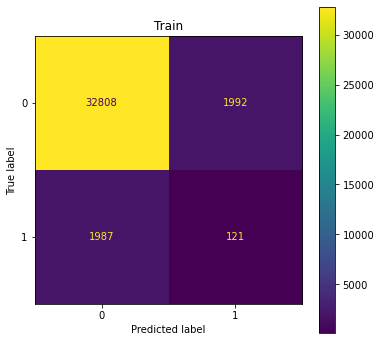

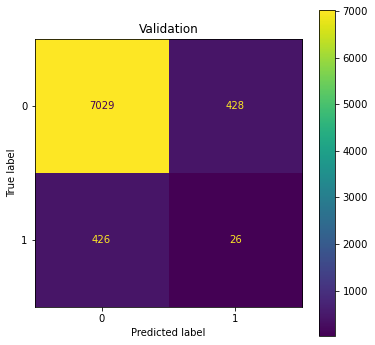

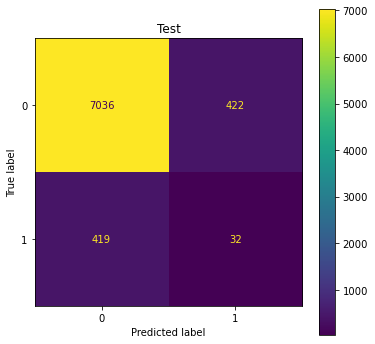

In [12]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_count.fit(X_train, y_train)

scores(pp_count, X_train, y_train, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Dummy
* Vectorizer: Tfidf
* Class Imbalance Solution: None

In [13]:
#instatiate the pipeline with vectorizer and dummy classifier model
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('dummy', DummyClassifier(random_state=42, strategy="stratified")),   
    ])

Train Scores
accuracy:  0.8921913948195513
recall:    0.05740037950664137
Validation Scores
accuracy:  0.8920217473764066
recall:    0.05752212389380531
Test Scores
accuracy:  0.8936654444303958
recall:    0.07095343680709534


(89.4, 7.1)

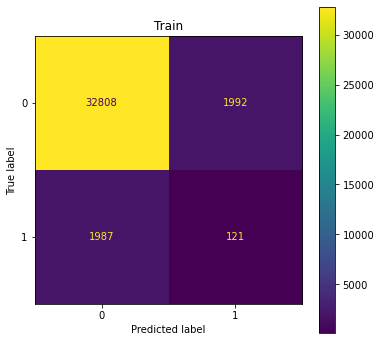

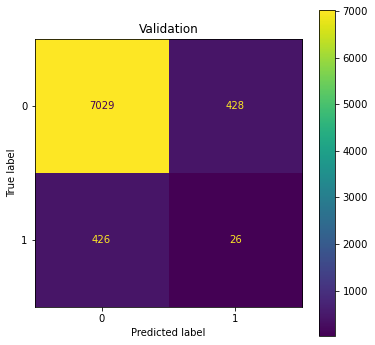

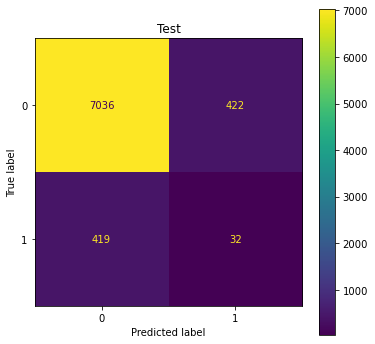

In [14]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

Though the accuracy is high for both the vectorizers through the dummy classifier model, the recall score was very poor. This is most likely due to the class imbalance. However, I will run a non-dummy, but simple logistic regression model to validate that the low recall score is not because of the dummy model itself.

### Model 1: Logistic Regression

The next model I decided to use is the logitic regression model.

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: None

In [15]:
#instatiate the pipeline with vectorizer and logistic regression
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.9490625338679961
recall:    0.21394686907020874
Validation Scores
accuracy:  0.9313440384372235
recall:    0.06858407079646017
Test Scores
accuracy:  0.933240611961057
recall:    0.07095343680709534


(93.3, 7.1)

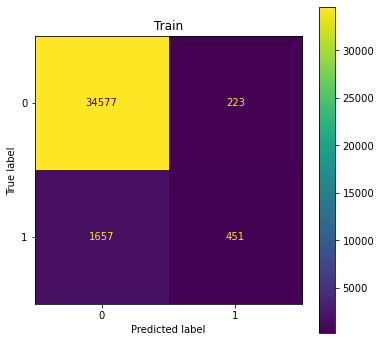

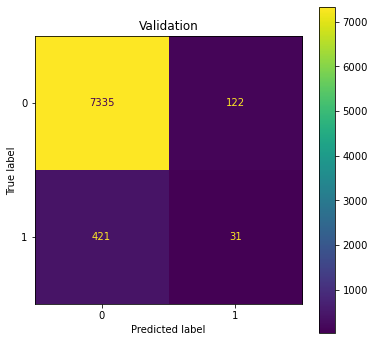

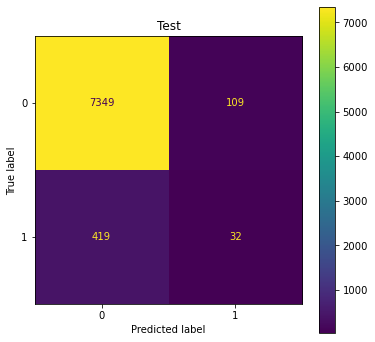

In [16]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_count.fit(X_train, y_train)

scores(pp_count, X_train, y_train, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: None

In [17]:
#instatiate the pipeline with vectorizer and logistic regression
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.9432372385390702
recall:    0.006641366223908918
Validation Scores
accuracy:  0.943229232519914
recall:    0.00663716814159292
Test Scores
accuracy:  0.943229232519914
recall:    0.004434589800443459


(94.3, 0.4)

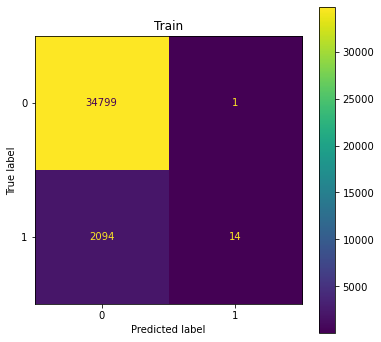

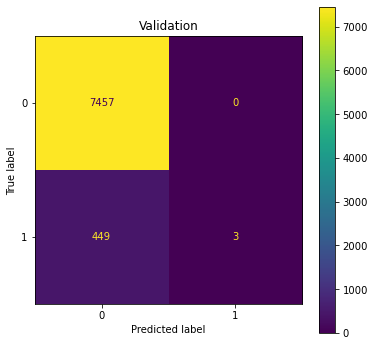

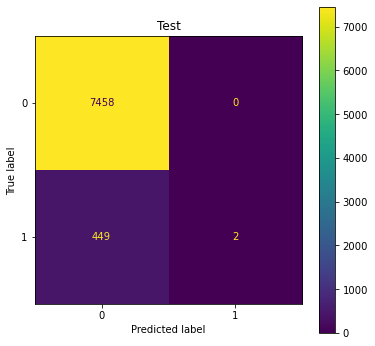

In [18]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

Again, the accuracy scores are high, but the recall scores are poor. Thus, for the next modeling step, I will try to improve the model by first trying to mitigate the class imbalance.

### Handling Imbalanced Data 

As mentioned before, the dataset is heavily imbalanced. I will implement three methods to handle the class imbalance:
* Undersample the negative cases
* Pass in class weights
* Implement SMOTE

#### Undersampling Negative Cases: 1 to 1

In [19]:
#concat the train dataset together
train_df = pd.concat([y_train, X_train], axis=1)

In [20]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [21]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=len(train_df_pos), random_state=42)

In [22]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [23]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [24]:
#split out the X and y of the new dataset
y_train_1 = new_train_df['READMISSION']
X_train_1 = new_train_df['TEXT']
max_feats_1 = int(X_train_1.shape[0]*0.10)

#### Undersampling Negative Cases: 2 to 1

In [25]:
#concat the train dataset together
train_df = pd.concat([y_train, X_train], axis=1)

In [26]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [27]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=2*len(train_df_pos), random_state=42)

In [28]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [29]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [30]:
#split out the X and y of the new dataset
y_train_2 = new_train_df['READMISSION']
X_train_2 = new_train_df['TEXT']
max_feats_2 = int(X_train_2.shape[0]*0.10)

#### Undersampling Negative Cases: 3 to 1

In [31]:
#concat the train dataset together
train_df = pd.concat([y_train, X_train], axis=1)

In [32]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [33]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=3*len(train_df_pos), random_state=42)

In [34]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [35]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [36]:
#split out the X and y of the new dataset
y_train_3 = new_train_df['READMISSION']
X_train_3 = new_train_df['TEXT']
max_feats_3 = int(X_train_3.shape[0]*0.10)

#### Class Weights

In [37]:
#calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=[0,1],y=y_train)

In [38]:
class_weights

array([0.53028736, 8.75426945])

### Model 1.1: Logistic Regression - Undersampling

In this section, I applied the undersampled dataset to logistic regression model.

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: Undersampling Negative 1:1

In [39]:
#instatiate the pipeline with vectorizer and logistic regression
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.7118121442125237
recall:    0.6902277039848197
Validation Scores
accuracy:  0.6610190921734732
recall:    0.5995575221238938
Test Scores
accuracy:  0.66986976861803
recall:    0.6208425720620843


(67.0, 62.1)

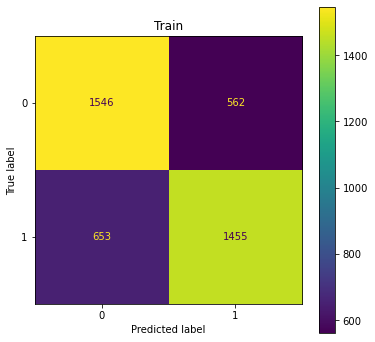

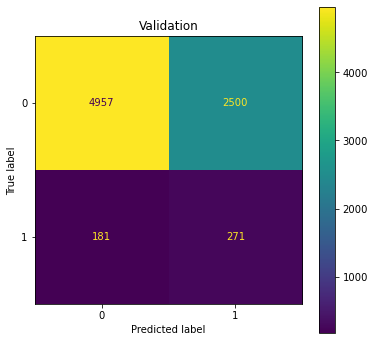

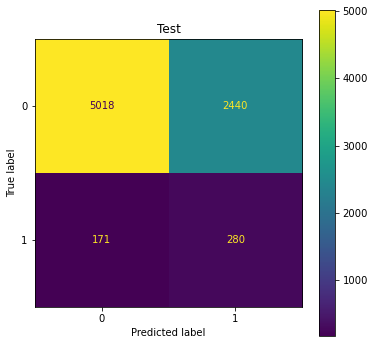

In [40]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_count.fit(X_train_1, y_train_1)

scores(pp_count, X_train_1, y_train_1, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Undersampling Negative 1:1

In [41]:
#instatiate the pipeline with vectorizer and logistic regression
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.6954459203036053
recall:    0.6987666034155597
Validation Scores
accuracy:  0.6521684157289164
recall:    0.6438053097345132
Test Scores
accuracy:  0.6603869009988621
recall:    0.6430155210643016


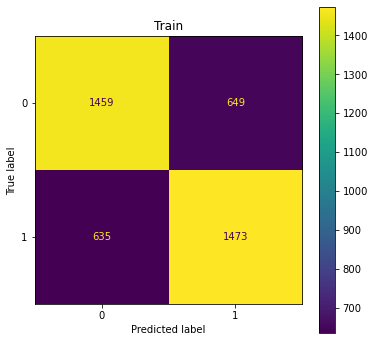

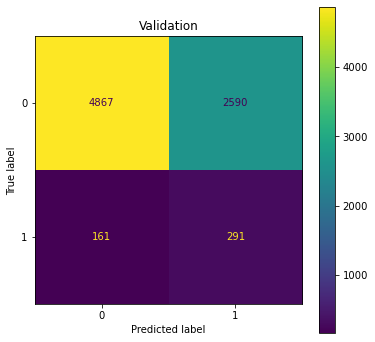

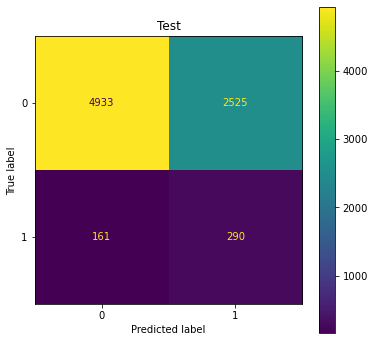

In [42]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_tfidf.fit(X_train_1, y_train_1)

scores(pp_tfidf, X_train_1, y_train_1, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
log_acc, log_recall = scores(pp_tfidf, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: Undersampling Negative 2:1

In [43]:
#instatiate the pipeline with vectorizer and logistic regression
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats_2)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.7583807716635041
recall:    0.5033206831119544
Validation Scores
accuracy:  0.796560880010115
recall:    0.3805309734513274
Test Scores
accuracy:  0.8023770388165381
recall:    0.42572062084257206


(80.2, 42.6)

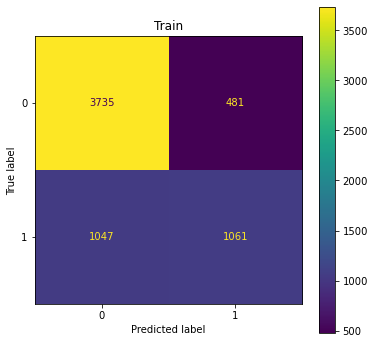

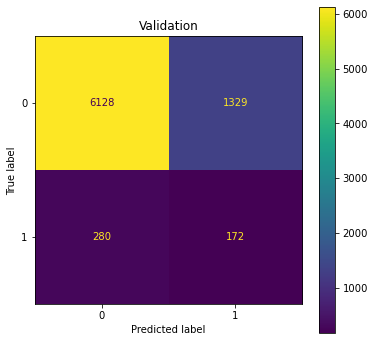

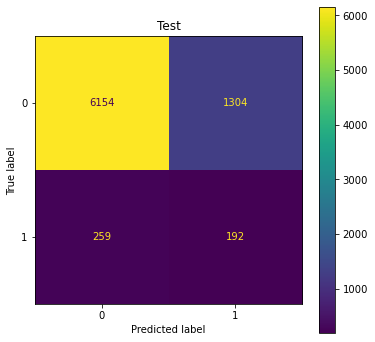

In [44]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_count.fit(X_train_2, y_train_2)

scores(pp_count, X_train_2, y_train_2, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Undersampling Negative 2:1

In [45]:
#instatiate the pipeline with vectorizer and logistic regression
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_2)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.7338709677419355
recall:    0.3894686907020873
Validation Scores
accuracy:  0.8511821974965229
recall:    0.3141592920353982
Test Scores
accuracy:  0.8534580857251233
recall:    0.35476718403547675


(85.3, 35.5)

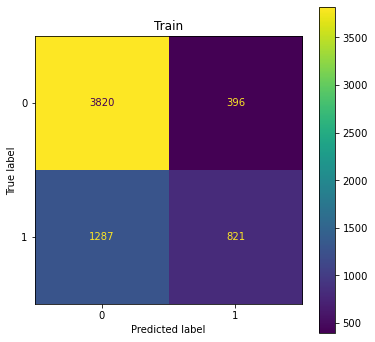

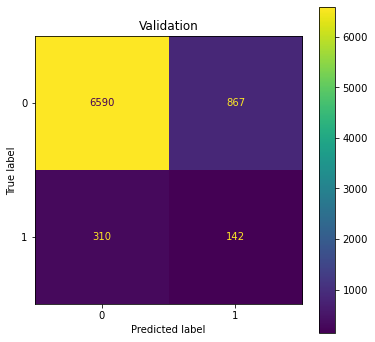

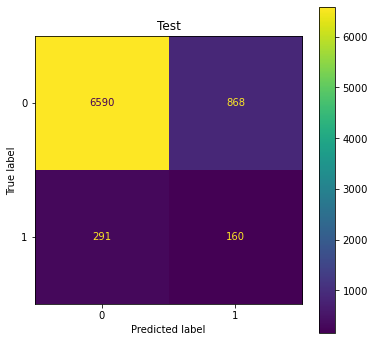

In [46]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_tfidf.fit(X_train_2, y_train_2)

scores(pp_tfidf, X_train_2, y_train_2, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: Undersampling Negative 3:1

In [47]:
#instatiate the pipeline with vectorizer and logistic regression
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats_3)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.8006404174573055
recall:    0.40702087286527516
Validation Scores
accuracy:  0.8515615122012896
recall:    0.3141592920353982
Test Scores
accuracy:  0.8428372739916551
recall:    0.31263858093126384


(84.3, 31.3)

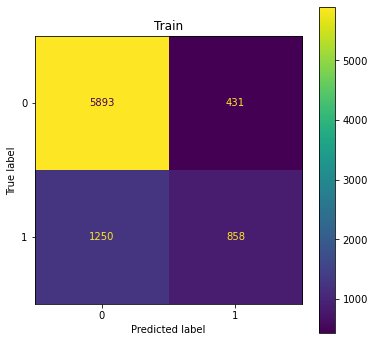

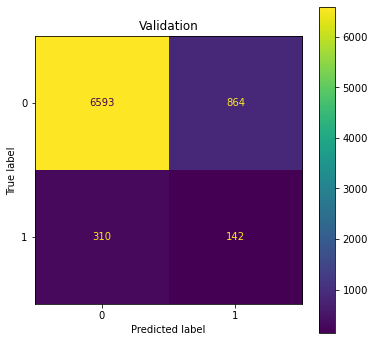

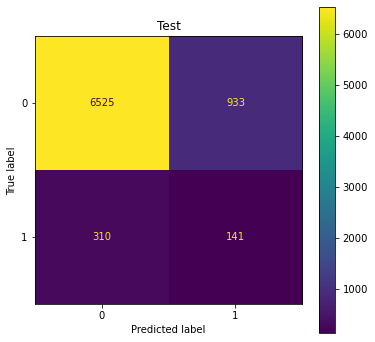

In [48]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_count.fit(X_train_3, y_train_3)

scores(pp_count, X_train_3, y_train_3, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Undersampling Negative 3:1

In [49]:
#instatiate the pipeline with vectorizer and logistic regression
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_3)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.7775142314990512
recall:    0.21869070208728653
Validation Scores
accuracy:  0.9055506385130864
recall:    0.15265486725663716
Test Scores
accuracy:  0.9070678973321532
recall:    0.18625277161862527


(90.7, 18.6)

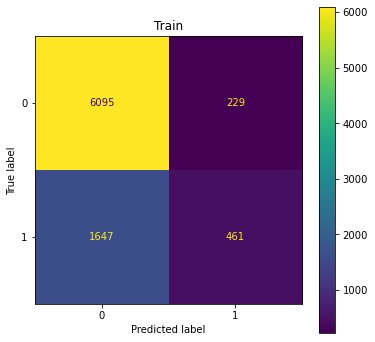

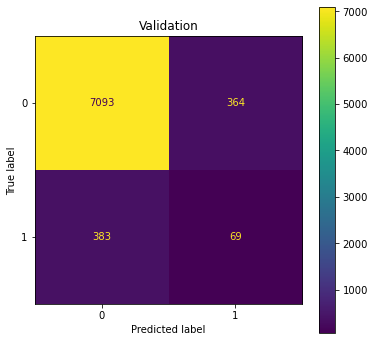

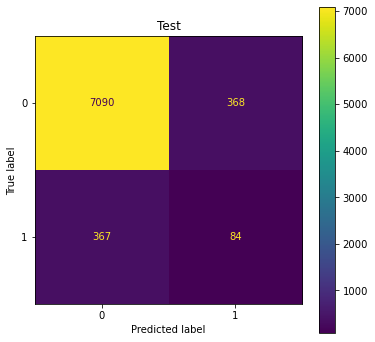

In [50]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_tfidf.fit(X_train_3, y_train_3)

scores(pp_tfidf, X_train_3, y_train_3, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

After using the undersampled dataset, though the accuracy went down, the recall score went up. The ratio of 1 to 1 of negative to positive cases had the best recall scores. In addition, the tfidf vectorizer performed better than the count vectorizer, and so we will just use the tfidf vectorizer. I saved down the scores of the logistic regression with the 1:1 negative undersampling and tfidf vectorizer.

### Model 1.2: Logistic Regression - Class Weights

In this section, I passed in the class weights in the logistic regression model.

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Class Weights

In [51]:
#instatiate the pipeline with vectorizer and logistic regression
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('logreg', LogisticRegression(random_state=42, class_weight=class_weights)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:680: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":


Train Scores
accuracy:  0.9432372385390702
recall:    0.006641366223908918
Validation Scores
accuracy:  0.943229232519914
recall:    0.00663716814159292
Test Scores
accuracy:  0.943229232519914
recall:    0.004434589800443459


(94.3, 0.4)

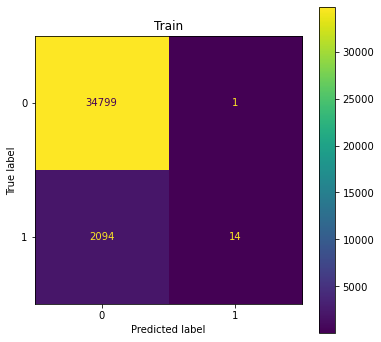

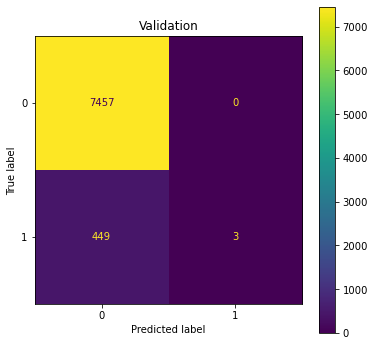

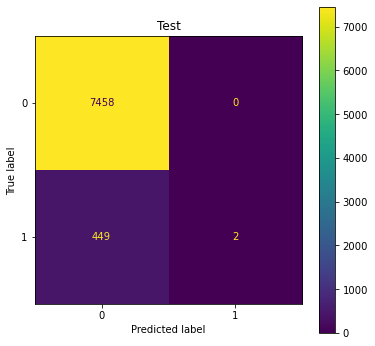

In [52]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

As seen above, passing in the class weights did not improve the recall score.

### Model 1.3: Logistic Regression - SMOTE

In this section, I utilized SMOTE to oversample the imbalanced class.

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: SMOTE

In [53]:
#instatiate the pipeline with vectorizer and logistic regression
pp_tfidf = imbpipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(random_state=42))   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.8120461688522813
recall:    0.7722960151802657
Validation Scores
accuracy:  0.7825262359337464
recall:    0.5
Test Scores
accuracy:  0.7820204829940574
recall:    0.4878048780487805


(78.2, 48.8)

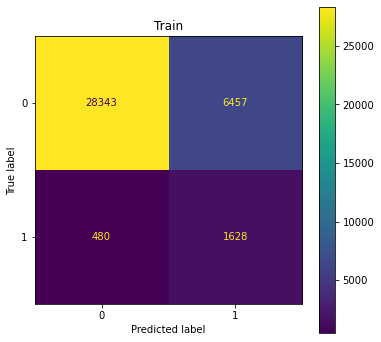

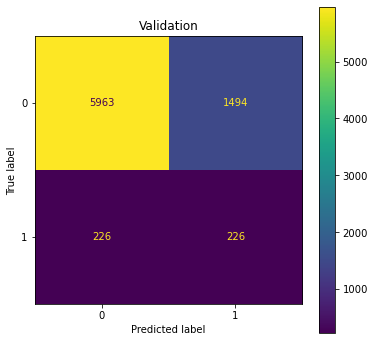

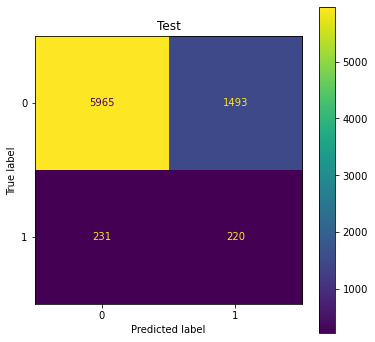

In [54]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

SMOTE did improve the recall score. However, running SMOTE into grid search will take too much computation power. In addition, it led to the model overfitting. Therefore, I will not utilize SMOTE.

### Introducing N-Grams

I wanted to test if introducing n-grams into the data to see if it improves the score.

In [55]:
#instatiate the pipeline with vectorizer and logistic regression
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1, ngram_range=(1,3))),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.6930740037950665
recall:    0.7044592030360531
Validation Scores
accuracy:  0.6412947275256038
recall:    0.6415929203539823
Test Scores
accuracy:  0.6498925275003161
recall:    0.6541019955654102


(65.0, 65.4)

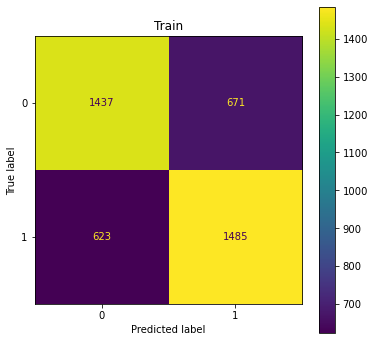

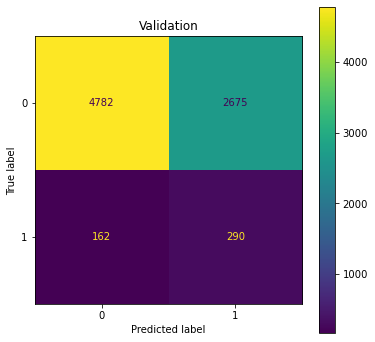

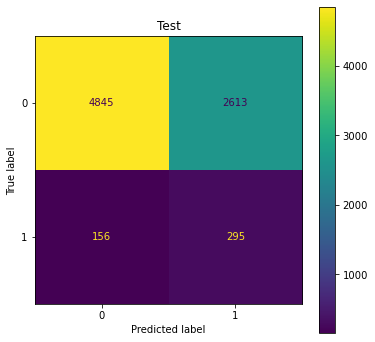

In [56]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_tfidf.fit(X_train_1, y_train_1)

scores(pp_tfidf, X_train_1, y_train_1, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

The scores did not improve very much. In addition, n-grams were slightly more overfitting without this model.

### Model 2: Multinomial Naive Bayes

For this model, I utilized multinomial Naive Bayes model.

In [57]:
#instatiate the pipeline with vectorizer and multinomial Naive Bayes model
mnb = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('mnb', MultinomialNB())   
    ])

Train Scores
accuracy:  0.639943074003795
recall:    0.6740986717267552
Validation Scores
accuracy:  0.6003287394107978
recall:    0.6415929203539823
Test Scores
accuracy:  0.6036161335187761
recall:    0.6629711751662971


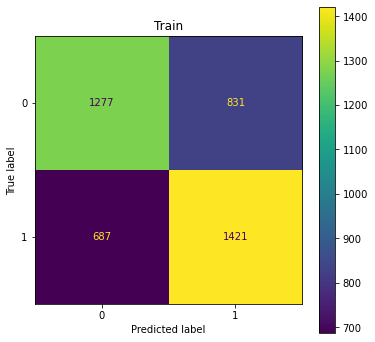

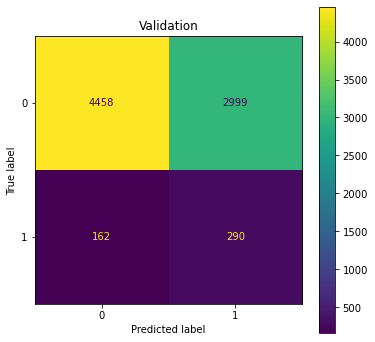

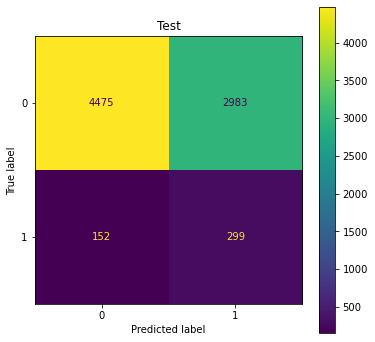

In [58]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
mnb.fit(X_train_1, y_train_1)

scores(mnb, X_train_1, y_train_1, 'Train')
scores(mnb, X_val, y_val, 'Validation')
mnb_acc, mnb_recall = scores(mnb, X_test, y_test, 'Test')

The multinomial Naive Bayes model resulted in a higher sensitivity score, but a lower accuracy score of the scores of the logistic regression model.

### Model 3: Random Forest

For this model, I utilized Random Forest model.

In [59]:
#instatiate the pipeline with vectorizer and Random Forest model
pp_rf = Pipeline(steps=[
    #decreased the number of features to reduce overfitting
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=int(max_feats_1*0.1))), 
    ('rf', RandomForestClassifier(random_state=42))   
    ])

In [60]:
grid = {'rf__max_depth': [3,5,8,10],
        'rf__max_features': ['auto', 'sqrt'],
        'rf__min_samples_leaf': [2, 5, 10, 20, 30, 50],
        'rf__min_samples_split': [2, 5, 7, 10, 20, 50]}

In [61]:
#grid search
gs_rf = GridSearchCV(estimator=pp_rf, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

I ran the grid search but commented out the code so that it did not have to run everytime I reran the notebook. I saved the results below.

In [62]:
# gs_rf.fit(X_train_1, y_train_1)

# scores(gs_rf, X_train_1, y_train_1, 'Train')
# scores(gs_rf, X_val, y_val, 'Validation')
# rf_acc, rf_recall = scores(gs_rf, X_test, y_test, 'Test')

In [63]:
# gs_rf.best_params_

In [64]:
"""
{'rf__max_depth': 3,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 5,
 'rf__min_samples_split': 20}
"""

"\n{'rf__max_depth': 3,\n 'rf__max_features': 'auto',\n 'rf__min_samples_leaf': 5,\n 'rf__min_samples_split': 20}\n"

In [65]:
#instatiate the pipeline with vectorizer and Random Forest model, with metrics from
#the grid search
pp_rf = Pipeline(steps=[
    #decreased the number of features to reduce overfitting
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=int(max_feats_1*0.1))), 
    ('rf', RandomForestClassifier(random_state=42,
                                  max_depth=3,
                                  max_features='auto',
                                  min_samples_leaf=5,
                                  min_samples_split=20))   
    ])

Train Scores
accuracy:  0.6411290322580645
recall:    0.6940227703984819
Validation Scores
accuracy:  0.5694778100897712
recall:    0.6548672566371682
Test Scores
accuracy:  0.5787078012390947
recall:    0.6784922394678492


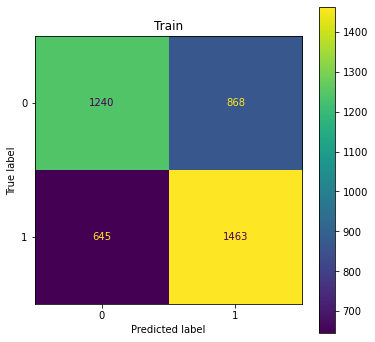

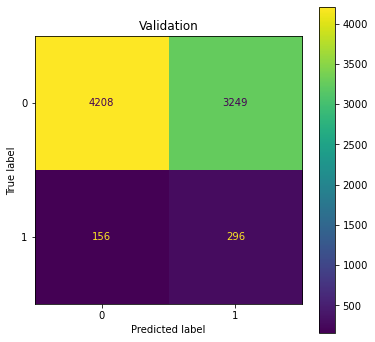

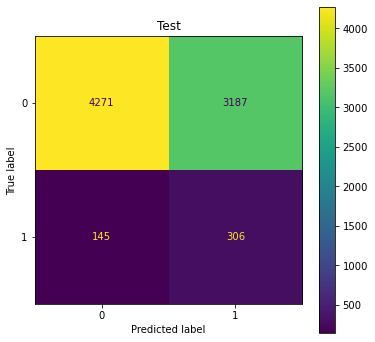

In [66]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_rf.fit(X_train_1, y_train_1)

scores(pp_rf, X_train_1, y_train_1, 'Train')
scores(pp_rf, X_val, y_val, 'Validation')
rf_acc, rf_recall = scores(pp_rf, X_test, y_test, 'Test')

The Random Forest model had an higher recall score than the previous models, but had a lower accuracy score.

### Model 4: K-Nearest Neighbors

For this model, I utilized K-Nearest Neighbors (KNN) model.

In [67]:
#instatiate the pipeline with vectorizer and KNN model
pp_knn = Pipeline(steps=[
    #decreased the number of features to reduce overfitting
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=int(max_feats_1*0.1))),
    ('knn', KNeighborsClassifier())   
    ])

In [68]:
grid = {'knn__n_neighbors': list(range(1, 20, 2)),
        'knn__weights': ['uniform', 'distance'],
        'knn__p': [1,2,3,4]}

In [69]:
#grid search
gs_knn = GridSearchCV(estimator=pp_knn, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

I ran the grid search but commented out the code so that it did not have to run everytime I reran the notebook. I saved the results below.

In [70]:
# gs_knn.fit(X_train_1, y_train_1)

# scores(gs_knn, X_train_1, y_train_1, 'Train')
# scores(gs_knn, X_val, y_val, 'Validation')
# knn_acc, knn_recall = scores(gs_knn, X_test, y_test, 'Test')

In [71]:
# gs_knn.best_params_

In [72]:
"""
{'knn__n_neighbors': 19, 'knn__p': 2, 'knn__weights': 'uniform'}
"""

"\n{'knn__n_neighbors': 19, 'knn__p': 2, 'knn__weights': 'uniform'}\n"

In [73]:
#instatiate the pipeline with vectorizer and KNN model, with metrics from
#the grid search
pp_knn = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=int(max_feats_1*0.1))),
    ('knn', KNeighborsClassifier(n_neighbors=19,
                                 p=2,
                                 weights='uniform'))   
    ])

Train Scores
accuracy:  0.6582068311195446
recall:    0.75426944971537
Validation Scores
accuracy:  0.5022126691111392
recall:    0.6504424778761062
Test Scores
accuracy:  0.514730054368441
recall:    0.7139689578713969


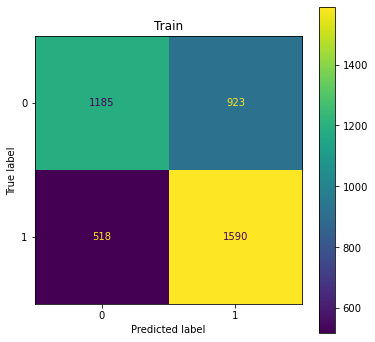

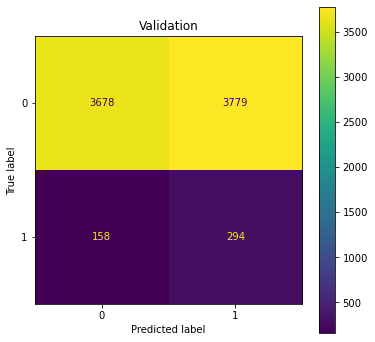

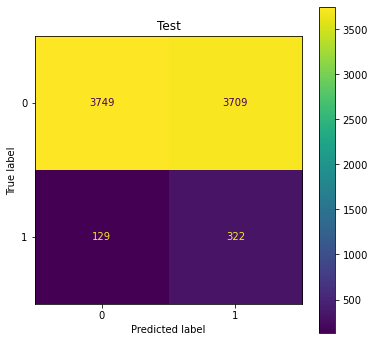

In [74]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_knn.fit(X_train_1, y_train_1)

scores(pp_knn, X_train_1, y_train_1, 'Train')
scores(pp_knn, X_val, y_val, 'Validation')
knn_acc, knn_recall = scores(pp_knn, X_test, y_test, 'Test')

The KNN model had an higher recall score than the previous models, but had a lower accuracy score.

### Model 5: Decision Tree Model

For this model, I utilized Decision Tree model.

In [75]:
#instatiate the pipeline with vectorizer and decision tree model
pp_dt = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('dt', DecisionTreeClassifier(random_state=42, criterion='entropy'))   
    ])

In [76]:
grid = {'dt__max_depth': np.arange(1, 17, 3),
        'dt__min_samples_split': np.arange(20, 101, 10),
        'dt__min_samples_leaf': np.arange(20, 101, 10)
       }

In [77]:
#grid search
gs_dt = GridSearchCV(estimator=pp_dt, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

I ran the grid search but commented out the code so that it did not have to run everytime I reran the notebook. I saved the results below.

In [78]:
# gs_dt.fit(X_train_1, y_train_1)

# scores(gs_dt, X_train_1, y_train_1, 'Train')
# scores(gs_dt, X_val, y_val, 'Validation')
# dt_acc, dt_recall = scores(gs_dt, X_test, y_test, 'Test')

In [79]:
# gs_dt.best_params_

In [80]:
"""
{'dt__max_depth': 1, 'dt__min_samples_leaf': 20, 'dt__min_samples_split': 20}
"""

"\n{'dt__max_depth': 1, 'dt__min_samples_leaf': 20, 'dt__min_samples_split': 20}\n"

In [81]:
#instatiate the pipeline with vectorizer and decision tree model, with metrics from
#the grid search
pp_dt = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('dt', DecisionTreeClassifier(random_state=42,
                                  criterion='entropy',
                                  max_depth=1,
                                  min_samples_leaf=20,
                                  min_samples_split=20))   
    ])

Train Scores
accuracy:  0.601280834914611
recall:    0.5531309297912713
Validation Scores
accuracy:  0.6354785687191806
recall:    0.5619469026548672
Test Scores
accuracy:  0.6357314451890251
recall:    0.5343680709534369


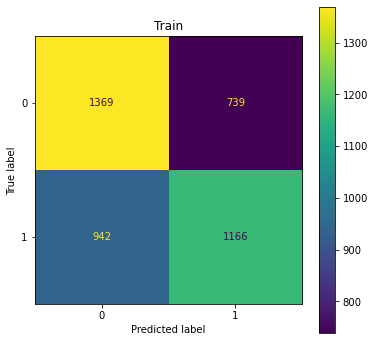

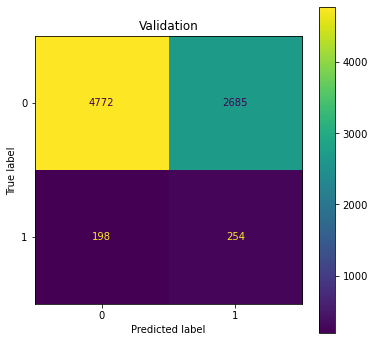

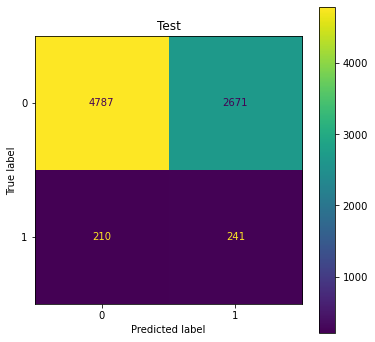

In [82]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_dt.fit(X_train_1, y_train_1)

scores(pp_dt, X_train_1, y_train_1, 'Train')
scores(pp_dt, X_val, y_val, 'Validation')
dt_acc, dt_recall = scores(pp_dt, X_test, y_test, 'Test')

The Decision Tree model had an lower recall score than the previous models, but had a higher accuracy score.

### Model 6: Gradient Boost

For this model, I utilized Gradient Boost model.

In [83]:
#instatiate the pipeline with vectorizer and gradient boost model
pp_gbc = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=int(max_feats_1*0.1))),
    ('gbc', GradientBoostingClassifier(random_state=42))   
    ])

In [84]:
grid = {'gbc__max_features': ['auto','log2'],
        'gbc__min_samples_split':[500, 600, 700, 800, 900, 1000],
        'gbc__min_samples_leaf':[5, 10, 20, 50, 100],
        'gbc__max_depth':[2, 3, 5, 10, 20]
       }

In [85]:
#grid search
gs_gbc = GridSearchCV(estimator=pp_gbc, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

I ran the grid search but commented out the code so that it did not have to run everytime I reran the notebook. I saved the results below.

In [86]:
# gs_gbc.fit(X_train_1, y_train_1)

# scores(gs_gbc, X_train_1, y_train_1, 'Train')
# scores(gs_gbc, X_val, y_val, 'Validation')
# scores(gs_gbc, X_test, y_test, 'Test')

In [87]:
# gs_gbc.best_params_

In [88]:
"""
{'gbc__max_depth': 2,
 'gbc__max_features': 'log2',
 'gbc__min_samples_leaf': 50,
 'gbc__min_samples_split': 500
"""

"\n{'gbc__max_depth': 2,\n 'gbc__max_features': 'log2',\n 'gbc__min_samples_leaf': 50,\n 'gbc__min_samples_split': 500\n"

In [89]:
#instatiate the pipeline with vectorizer and gradient boost model, with metrics from
#the grid search, but modified the metrics to reduce overfitting
pp_gbc = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=int(max_feats_1*0.1))),
    ('gbc', GradientBoostingClassifier(random_state=42,
                                       max_depth= 2,
                                       max_features= 'log2',
                                       #I adjusted parameters to decrease overfitting
                                       min_samples_leaf= 100, 
                                       min_samples_split= 500))   
    ])

Train Scores
accuracy:  0.6842979127134725
recall:    0.7210626185958254
Validation Scores
accuracy:  0.6057655835124541
recall:    0.6637168141592921
Test Scores
accuracy:  0.6105702364394993
recall:    0.6629711751662971


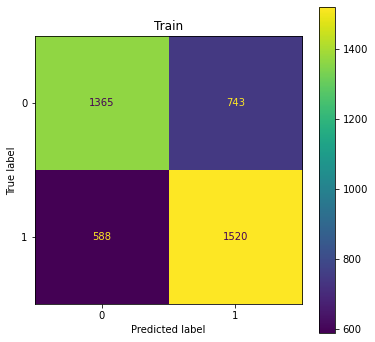

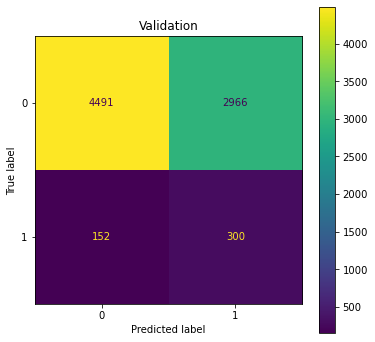

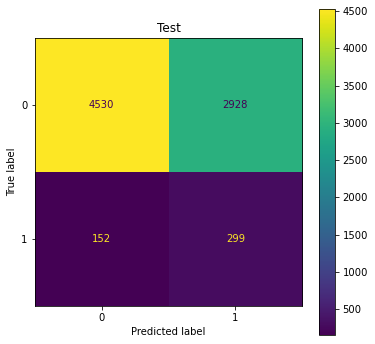

In [90]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
pp_gbc.fit(X_train_1, y_train_1)

scores(pp_gbc, X_train_1, y_train_1, 'Train')
scores(pp_gbc, X_val, y_val, 'Validation')
gbc_acc, gbc_recall = scores(pp_gbc, X_test, y_test, 'Test')

The Gradient Boost model, though did not have the best scores, had the best overall recall and accuracy score.

### Model 7: Ensemble

For this model, I utilized Ensemble/Voting model.

In [91]:
#instatiate the pipeline with vectorizer and logistic regression model
pp_logreg = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

In [92]:
#instatiate the voting classfier using the several models from above
voting_clf = VotingClassifier(estimators={("logreg", pp_logreg),
                                          ("mnb", mnb),
                                          ("rf", pp_rf),
                                          ('knn', pp_knn),
                                          #('dt', pp_dt), commented out to improve scores
                                          ("gbc", pp_gbc)
                                        },
                              voting= "soft")

Train Scores
accuracy:  0.6904648956356736
recall:    0.7281783681214421
Validation Scores
accuracy:  0.6089265393855102
recall:    0.6592920353982301
Test Scores
accuracy:  0.6215703628777343
recall:    0.7006651884700665


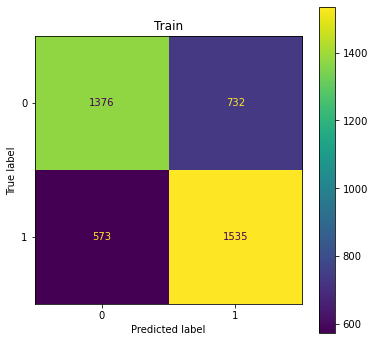

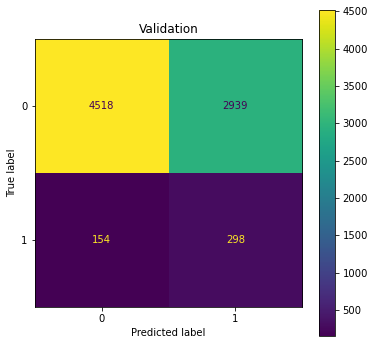

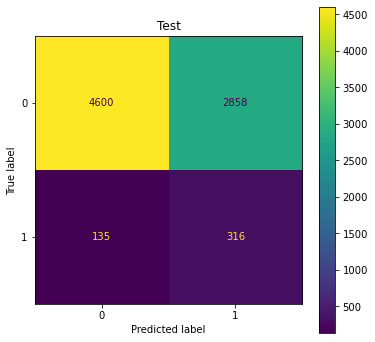

In [93]:
#fit the pipeline and retrieve the scores of train, validation, and test scores
voting_clf.fit(X_train_1, y_train_1)

scores(voting_clf, X_train_1, y_train_1, 'Train')
scores(voting_clf, X_val, y_val, 'Validation')
figure_test, vot_acc, vot_recall = scores(voting_clf, X_test, y_test, 'Test', return_conf=True)
figure_test.savefig('images/Model_Set1_Test_CF.png', bbox_inches='tight')

The Voting Classifier model had the best overal recall and accuracy score.

## Reviewing All Models:

In [94]:
X_labels = ['Logistic''\n''Regression', 'Multinomial''\n''Naive Bayes', 'Random''\n''Forest', 'KNN', 'Decision''\n''Tree', 'Gradient''\n''Boost', 'Ensemble''\n''(Vote)']
y1 = [log_recall, mnb_recall, rf_recall, knn_recall, dt_recall, gbc_recall, vot_recall]

In [95]:
y2 = [log_acc, mnb_acc, rf_acc, knn_acc, dt_acc, gbc_acc, vot_acc]

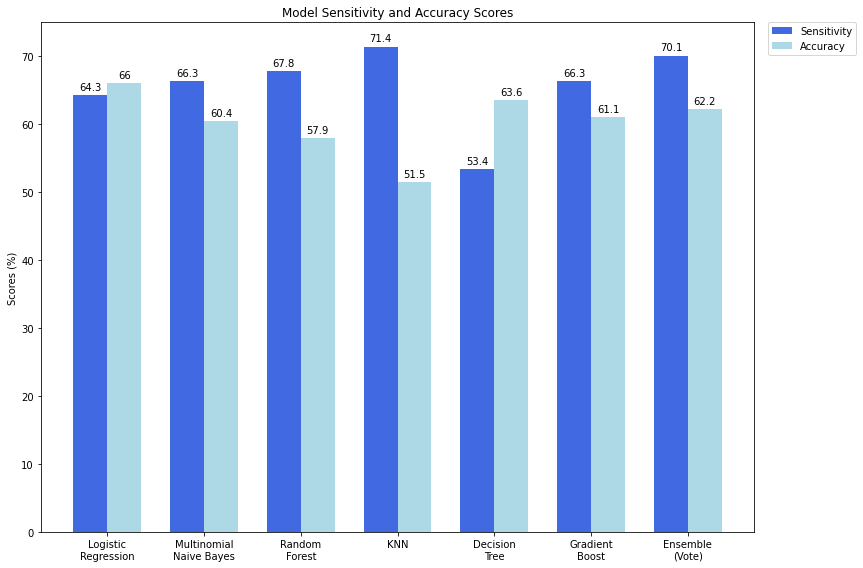

In [96]:
width = 0.35  # the width of the bars
x = np.arange(len(X_labels))
fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, y1, width, label='Sensitivity', color='royalblue')
rects2 = ax.bar(x + width/2, y2, width, label='Accuracy', color='lightblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores (%)')
ax.set_title('Model Sensitivity and Accuracy Scores')
ax.set_xticks(x)
ax.set_xticklabels(X_labels)
ax.legend(bbox_to_anchor=(1.15, 1.01))

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
#set background color to white
fig.patch.set_facecolor('white')
plt.show()
#save the figure in the images folder
fig.savefig('images/Model_Scores.png', bbox_inches='tight')

## Setting Final Model

In [97]:
#split the positive and negative data
df_pos = df[df['READMISSION']==1]
df_neg = df[df['READMISSION']==0]

In [98]:
#take a sample of the negative training set with the same number of rows as positive dataset
df_neg_samp = df_neg.sample(n=len(df_pos), random_state=42)

In [99]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_df = pd.concat([df_pos,df_neg_samp],axis=0)

In [100]:
#randomize the new dataset
new_df = new_df.sample(n=len(new_df), random_state=42)

In [101]:
#split out the X and y of the new dataset
new_y = new_df['READMISSION']
new_X = new_df['TEXT']
new_max_feats = int(new_X.shape[0]*0.10)

In [102]:
final_model = voting_clf

Final Scores
accuracy:  0.6353601638660243
recall:    0.7143806044503487


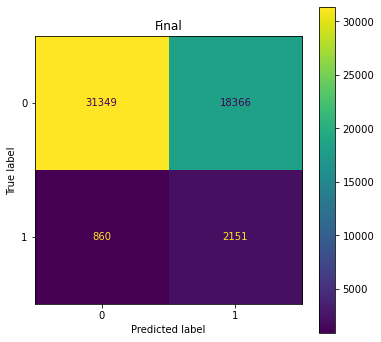

In [103]:
final_model.fit(new_X, new_y)
final_acc, final_recall = scores(final_model, X, y, 'Final')

In [104]:
y_preds = final_model.predict(X)
y_probs = final_model.predict_proba(X)

In [105]:
y_preds = pd.DataFrame(y_preds)
y_probs = pd.DataFrame(y_probs)

In [106]:
y_probs.drop(0, axis=1, inplace=True)

## Merging Results to Other Features and Exporting Data

In [107]:
new_df1 = df.copy()
new_df2 = df.copy()

new_df1 = new_df1.merge(y_preds, left_index=True, right_index=True)
new_df1.drop('TEXT', axis=1, inplace=True)
new_df1.rename(columns={0: 'TEXT'}, inplace=True)
                        
new_df2 = new_df2.merge(y_probs, left_index=True, right_index=True)
new_df2.drop('TEXT', axis=1, inplace=True)
new_df2.rename(columns={1: 'TEXT'}, inplace=True)

In [108]:
#export the modified dataframe with predicted classifications to the data folder
new_df1.to_csv("data/admissions_nlp_processed_1.csv.gz" , index = False,compression='gzip')

In [109]:
#export the modified dataframe with predicted probabilites to the data folder
new_df2.to_csv("data/admissions_nlp_processed_2.csv.gz" , index = False,compression='gzip')